In [9]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'chest-xray-pneumonia' dataset.
Path to dataset files: /kaggle/input/chest-xray-pneumonia


 Imports and Setup


In [10]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np


Data Preprocessing and Augmentation

In [11]:
img_size = 224
batch_size = 32

train_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/train'
val_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/val'
test_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/test'

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary'
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


 Build ResNet50 Model with Transfer Learning

In [18]:
# Load the ResNet50 model with pre-trained ImageNet weights, excluding the top classification layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

# Freeze the layers of the base model to prevent their weights from being updated during training
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Add a global average pooling layer
x = Dense(256, activation='relu')(x)  # Add a dense layer with ReLU activation
predictions = Dense(1, activation='sigmoid')(x)  # Add the output layer with sigmoid activation for binary classification

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,112,513 (91.98 MB)

 Trainable params: 524,801 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [12]:
import os

normal_imgs = os.listdir('/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL')
pneumonia_imgs = os.listdir('/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA')
print(f'Normal: {len(normal_imgs)}, Pneumonia: {len(pneumonia_imgs)}')

Normal: 1341, Pneumonia: 3875


In [16]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)

class_weight_dict = {i: w for i, w in enumerate(class_weights)}
print(f'Class weights: {class_weight_dict}')

Class weights: {0: np.float64(1.9448173005219984), 1: np.float64(0.6730322580645162)}


In [22]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    train_generator,
    epochs=20,                   # Set max epochs higher
    validation_data=validation_generator,
    class_weight=class_weight_dict,
    verbose=1,                   # Minimal progress bar per epoch
    callbacks=[early_stop]       # Stops training early if no improvement
)

Epoch 1/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 652ms/step - accuracy: 0.7587 - loss: 0.5325

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


163/163 ━━━━━━━━━━━━━━━━━━━━ 113s 692ms/step - accuracy: 0.7588 - loss: 0.5324 - val_accuracy: 0.7500 - val_loss: 0.5321
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 105s 646ms/step - accuracy: 0.7965 - loss: 0.4624 - val_accuracy: 0.6250 - val_loss: 0.5597
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 103s 633ms/step - accuracy: 0.8035 - loss: 0.4411 - val_accuracy: 0.6875 - val_loss: 0.5340
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 105s 643ms/step - accuracy: 0.8097 - loss: 0.4384 - val_accuracy: 0.6250 - val_loss: 0.5925


In [24]:
for layer in base_model.layers[-50:]:
    layer.trainable = True

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

finetune_history = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    class_weight=class_weight_dict,
    verbose=1,
    callbacks=[early_stop]
)

Epoch 1/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 135s 675ms/step - accuracy: 0.7981 - loss: 0.7226 - val_accuracy: 0.8125 - val_loss: 0.4269
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 105s 644ms/step - accuracy: 0.9073 - loss: 0.2263 - val_accuracy: 0.5625 - val_loss: 0.8634
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 105s 645ms/step - accuracy: 0.9082 - loss: 0.2114 - val_accuracy: 0.5625 - val_loss: 1.1844
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 105s 643ms/step - accuracy: 0.9105 - loss: 0.2126 - val_accuracy: 0.7500 - val_loss: 0.5945


In [25]:
from sklearn.metrics import confusion_matrix, classification_report

test_generator.reset()
y_pred_prob = model.predict(test_generator)
y_pred = (y_pred_prob > 0.5).astype(int).reshape(-1)
y_true = test_generator.classes

print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=['Normal', 'Pneumonia']))


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 482ms/step
Confusion Matrix:
 [[212  22]
 [169 221]]

Classification Report:
               precision    recall  f1-score   support

      Normal       0.56      0.91      0.69       234
   Pneumonia       0.91      0.57      0.70       390

    accuracy                           0.69       624
   macro avg       0.73      0.74      0.69       624
weighted avg       0.78      0.69      0.69       624



 Grad-CAM Visualization for ResNet50

In [27]:
!ls /kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/

person100_bacteria_475.jpeg  person1633_virus_2829.jpeg
person100_bacteria_477.jpeg  person1634_virus_2830.jpeg
person100_bacteria_478.jpeg  person1635_virus_2831.jpeg
person100_bacteria_479.jpeg  person1637_virus_2834.jpeg
person100_bacteria_480.jpeg  person1640_virus_2839.jpeg
person100_bacteria_481.jpeg  person1641_virus_2840.jpeg
person100_bacteria_482.jpeg  person1642_virus_2842.jpeg
person101_bacteria_483.jpeg  person1643_virus_2843.jpeg
person101_bacteria_484.jpeg  person1644_virus_2844.jpeg
person101_bacteria_485.jpeg  person1645_virus_2845.jpeg
person101_bacteria_486.jpeg  person1647_virus_2848.jpeg
person102_bacteria_487.jpeg  person1649_virus_2850.jpeg
person103_bacteria_488.jpeg  person1650_virus_2852.jpeg
person103_bacteria_489.jpeg  person1650_virus_2854.jpeg
person103_bacteria_490.jpeg  person1651_virus_2855.jpeg
person104_bacteria_491.jpeg  person1653_virus_2858.jpeg
person104_bacteria_492.jpeg  person1653_virus_2859.jpeg
person108_bacteria_504.jpeg  person1655_virus_28

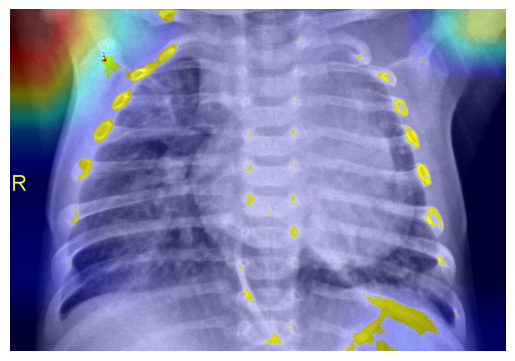

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Predicted label: NORMAL


In [31]:
import cv2

last_conv_layer_name = 'conv5_block3_out'  # Last conv layer in ResNet50

def get_img_array(img_path):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(img_size, img_size))
    array = tf.keras.preprocessing.image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array / 255.0

def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(conv_outputs * pooled_grads, axis=-1)
    heatmap = tf.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap.numpy()

def display_gradcam(img_path, heatmap):
    img = cv2.imread(img_path)
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_uint8 = np.uint8(255 * heatmap_resized)
    heatmap_color = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_JET)
    superimposed_img = heatmap_color * 0.4 + img
    plt.imshow(cv2.cvtColor(superimposed_img.astype('uint8'), cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# Example usage
test_image_path = '/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person100_bacteria_475.jpeg'
img_array = get_img_array(test_image_path)
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
display_gradcam(test_image_path, heatmap)


pred = model.predict(img_array)
print('Predicted label:', 'PNEUMONIA' if pred[0][0] > 0.5 else 'NORMAL')


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


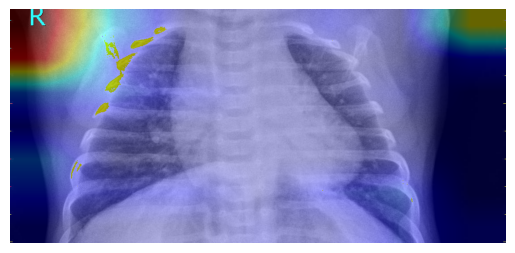

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
Predicted label: PNEUMONIA


In [36]:
# Change the path to the desired image
test_image_path = '/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person1633_virus_2829.jpeg'

img_array = get_img_array(test_image_path)
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
display_gradcam(test_image_path, heatmap)

pred = model.predict(img_array)
print('Predicted label:', 'PNEUMONIA' if pred[0][0] > 0.5 else 'NORMAL')


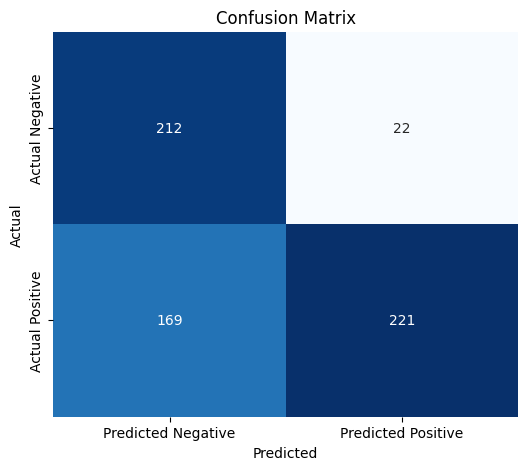

In [19]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Given confusion matrix
conf_matrix = np.array([[212, 22],
                        [169, 221]])

# Create a heatmap for the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])

# Adding labels and title
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

# Show the plot
plt.show()
